In [1]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import backend as K



In [36]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-06-07 04:56:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-07 04:56:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-07 04:56:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [4]:
!ls

glove.6B.100d.txt  glove.6B.50d.txt  sample_submission.csv  train.csv
glove.6B.200d.txt  glove.6B.zip      test.csv
glove.6B.300d.txt  sample_data	     test_labels.csv


In [41]:
embedding = "glove.6B.100d.txt"

In [6]:
!pwd

/content


In [42]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('/content/'+embedding) as f:
    
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [43]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [44]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [45]:
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")

In [56]:
testing_clean = pd.merge(test, test_labels)

In [47]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()

In [48]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [49]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


Found 210337 unique tokens.


In [50]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [61]:
data = data[:len(testing_clean)]

153164
(159571, 100)
(153164, 100)


In [14]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:

# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [52]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [ ]:
# Computing metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall + K.epsilon()))

In [53]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Building model...
Training model...
Epoch 1/10
998/998 [==============================] - 111s 110ms/step - loss: 0.0841 - accuracy: 0.9762 - val_loss: 0.0976 - val_accuracy: 0.9935
Epoch 2/10
998/998 [==============================] - 112s 112ms/step - loss: 0.0674 - accuracy: 0.9877 - val_loss: 0.0747 - val_accuracy: 0.9925
Epoch 3/10
998/998 [==============================] - 111s 111ms/step - loss: 0.0630 - accuracy: 0.9935 - val_loss: 0.0776 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 110s 110ms/step - loss: 0.0600 - accuracy: 0.9929 - val_loss: 0.0678 - val_accuracy: 0.9880
Epoch 5/10
998/998 [==============================] - 110s 110ms/step - loss: 0.0574 - accuracy: 0.9928 - val_loss: 0.0731 - val_accuracy: 0.9940
Epoch 6/10
998/998 [==============================] - 109s 109ms/step - loss: 0.0552 - accuracy: 0.9936 - val_loss: 0.0678 - val_accuracy: 0.9941
Epoch 7/10
998/998 [==============================] - 109s 109ms/step - loss: 0.0533 - a

In [63]:
y_test_cnn = model.predict([data], batch_size=BATCH_SIZE, verbose=1)

1197/1197 [==============================] - 45s 38ms/step


In [64]:
print(np.shape(np.argmax(testing_clean[possible_labels].values,axis=1)),np.shape(np.argmax(y_test_cnn, axis=1)))

(153164,) (153164,)


In [65]:
f1_score_ = f1_score(np.argmax(testing_clean[possible_labels].values, axis=1), np.argmax(y_test_cnn, axis=1), average="weighted")
f1_score_

0.9982896198528437

In [67]:
avg = 0
for i, label in enumerate(possible_labels):
    print(label, ":")
    pb = y_test_cnn[:, i] >= 0.5
    score = f1_score(testing_clean[label], pb, average="weighted")
    print(score)
    avg += score

avg /= len(possible_labels)
print("Average f1-score:", avg)

toxic :
0.20365135452459415
severe_toxic :
0.2436172027035526
obscene :
0.22010931916707308
threat :
0.24474372982543338
insult :
0.22143468430417407
identity_hate :
0.24139552583576418
Average f1-score: 0.22915863606009856


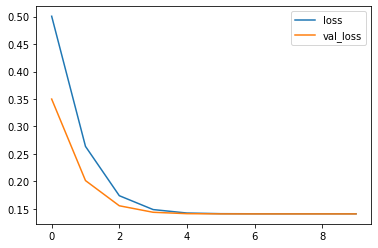

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

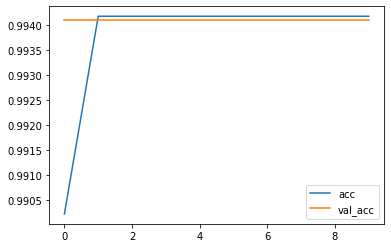

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.5
